First the boltzmann machine has weights between two given units. We can denote as $w_{ij}$

In [99]:
import random
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("dark_background")

In [100]:
class SymmetricWeights:
	def __init__(self, units):
		self.units = units
		self.data = []
		for i in range(units):
			r = []
			for j in range(units):
				if(i < j):
					r.append(random.random())
				else:
					r.append(None)
			self.data.append(r)

	def __getitem__(self, tup):
		i,j = tup
		assert(i != j)
		if i > j:
			i, j = j, i
		return self.data[i][j]

	def __repr__(self):
		return str(self.data)

w = SymmetricWeights(5)

In [101]:
for i in range(5):
	for j in range(5):
		if(i < j):
			print(w[i, j], end=" ")
		else:
			print("None", end=" ")
	print()

None 0.859119747833 0.891618364650744 0.36922520786349455 0.596554732474722 
None None 0.9563722826546089 0.7401482023517861 0.8525848399171184 
None None None 0.225307251414136 0.29728305150400247 
None None None None 0.708093448774806 
None None None None None 


next I'll visualize this symmetric matrix via matplotlib

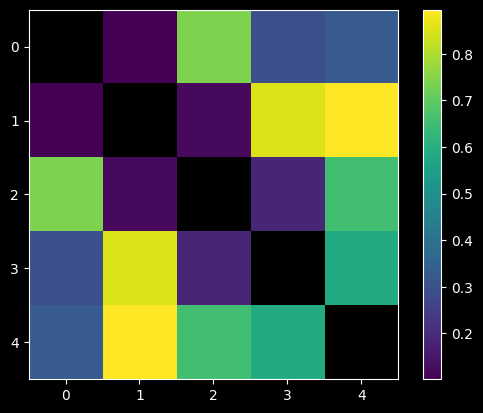

In [ ]:

def visualize_weights(w: SymmetricWeights):
	full = []
	for i in range(w.units):
		f = []
		for j in range(w.units):
			if(i != j):
				f.append(w[i, j])
			else:
				f.append(np.NaN)
		full.append(f)
	plt.imshow(np.array(full))
	plt.colorbar()
visualize_weights(w)